In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gym
from helpers import NormalizedEnv, RandomAgent
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from mpl_toolkits.mplot3d import Axes3D
from pylab import*
import os

## 3. Heuristic Policy

In [4]:
# Implement a heuristic policy
class HeuristicPendulumAgent():
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.agent_name='HeuristicPendulumAgent'

    def get_agent_name(self):
        return self.agent_name
        

    def compute_action(self, state,fix_torque=0.1):
         # When the pendulum is in the lower half of the domain (x<0)
         if state[0]<0:
             # applies a fixed torque in the same direction as the pendulum’s angular velocity
             return fix_torque*np.sign(state[2])
         # When the pendulum is in the higher half of the domain (x>0)
         else:
             # applies a fixed torque in the  opposite direction as the pendulum’s angular velocity
             return -1*fix_torque*np.sign(state[2])

In [5]:
def DoState(env,agent,observation,total_reward_per_episode,agent_name='RandomAgent',fix_torque=0.1):
    if agent_name=='HeuristicPendulumAgent':
        action = agent.compute_action(observation,fix_torque)
    else:
        action = agent.compute_action(observation)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    observation, reward, terminated, truncated, info = env.step(normalized_action)
    # print('observation:',observation)
    # print('reward:',reward)
    # print('terminated:',terminated)
    total_reward_per_episode += reward
    # print('total_reward:',total_reward)
    if terminated or truncated:
        observation, info = env.reset()

    return observation, info, total_reward_per_episode

def DoEpisode(env,agent,agent_name='RandomAgent',fix_torque=0.1,num_state=200) :
    observation, info = env.reset()
    total_reward_per_episode=0
    for _ in range(num_state):
        observation, info, total_reward_per_episode=DoState(env,agent,observation,total_reward_per_episode,agent_name,fix_torque)
        # print("total_reward_per_episode:",total_reward_per_episode)
    return total_reward_per_episode

c:\Users\yasmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


total_reward: -628.3330044253527
average_reward: -628.3330044253527
total_reward: -1815.633840518502
average_reward: -907.816920259251
total_reward: -3336.818671451486
average_reward: -1112.2728904838286
total_reward: -3839.1715310130658
average_reward: -959.7928827532664
total_reward: -4804.16835371509
average_reward: -960.833670743018
total_reward: -5876.80777523061
average_reward: -979.467962538435
total_reward: -6734.648445059444
average_reward: -962.092635008492
total_reward: -7356.204534942939
average_reward: -919.5255668678674
total_reward: -8533.730609449849
average_reward: -948.1922899388721
total_reward: -9516.07349369437
average_reward: -951.607349369437
total_reward: -1067.2826033233307
average_reward: -1067.2826033233307
total_reward: -2248.6201967964635
average_reward: -1124.3100983982317
total_reward: -3232.558768340873
average_reward: -1077.5195894469578
total_reward: -4406.028665357554
average_reward: -1101.5071663393885
total_reward: -5928.152018502975
average_reward:

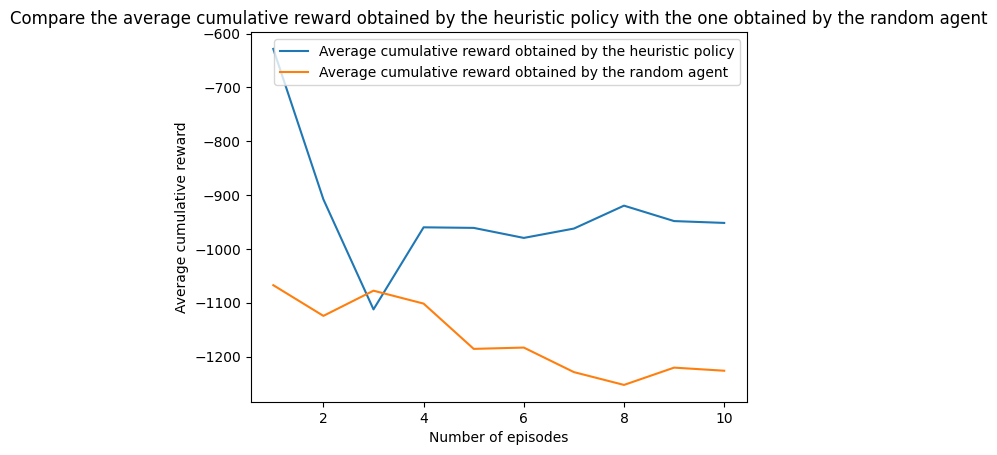

In [6]:
env = gym.make("Pendulum-v1")
num_episode=10
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to compare the average cumulative reward obtained by the heuristic policy 
# with the reward of the random agent
list_average_reward_HeuristicAgent=[]
total_episodes_reward_HeuristicAgent = 0
for episode in range(num_episode):
    agent = HeuristicPendulumAgent(env)
    total_reward_per_episode=DoEpisode(env, agent,agent.get_agent_name())
    total_episodes_reward_HeuristicAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_HeuristicAgent)
    average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_HeuristicAgent.append(average_reward)

list_average_reward_RandomAgent=[]
total_episodes_reward_RandomAgent = 0
for episode in range(num_episode):
    agent = RandomAgent(env)
    total_reward_per_episode=DoEpisode(env, agent)
    total_episodes_reward_RandomAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_RandomAgent)
    average_reward = total_episodes_reward_RandomAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_RandomAgent.append(average_reward)

list_number_episodes = np.linspace(1,10,num=10)

plt.plot(list_number_episodes,list_average_reward_HeuristicAgent,label= 'Average cumulative reward obtained by the heuristic policy')
plt.plot(list_number_episodes,list_average_reward_RandomAgent,label= 'Average cumulative reward obtained by the random agent')
plt.xlabel('Number of episodes')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.title('Compare the average cumulative reward obtained by the heuristic policy with the one obtained by the random agent')
plt.show()
env.close()

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
total_reward: -977.895447182966
average_reward: -977.895447182966
total_reward: -2559.986093393482
average_reward: -1279.993046696741
total_reward: -4062.591169406506
average_reward: -1354.1970564688354
total_reward: -5067.826738425327
average_reward: -1266.9566846063317
total_reward: -6160.181666956652
average_reward: -1232.0363333913306
total_reward: -7338.830706713982
average_reward: -1223.138451118997
total_reward: -8308.39646404139
average_reward: -1186.9137805773414
total_reward: -9886.686917526986
average_reward: -1235.8358646908732
total_reward: -10875.572330494968
average_reward: -1208.396925610552
total_reward: -12101.037453621866
average_reward: -1210.1037453621866
total_reward: -502.5412320838857
average_reward: -502.5412320838857
total_reward: -1857.1178480254994
average_reward: -928.5589240127497
total_reward: -2599.090094934183
average_reward: -866.363364978061
total_reward: -3100.80528312

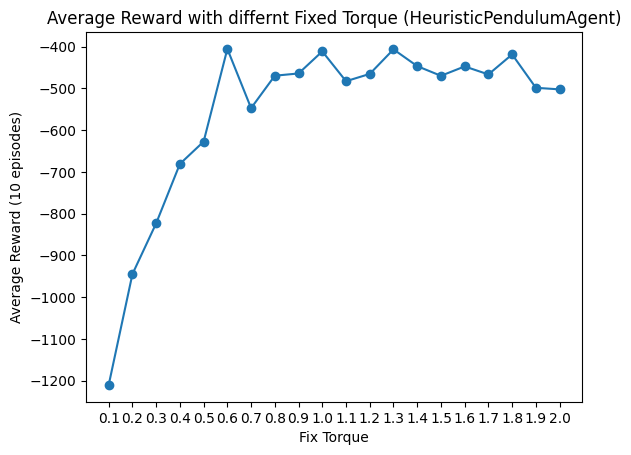

In [7]:
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to show the impact of different amplitude of the fixed torque have on the reward
env = gym.make("Pendulum-v1")
num_episode=10
list_last_average_reward=[]
list_fix_torque=np.linspace(0.1, 2.0, num=20)
print(list_fix_torque)
for fix_torque in list_fix_torque:
    total_episodes_reward_HeuristicAgent=0
    for episode in range(num_episode):
        agent = HeuristicPendulumAgent(env)
        total_reward_per_episode=DoEpisode(env,agent,agent.get_agent_name(),fix_torque)
        total_episodes_reward_HeuristicAgent += total_reward_per_episode
        print('total_reward:', total_episodes_reward_HeuristicAgent)
        average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
        print('average_reward:', average_reward)
    list_last_average_reward.append(average_reward)
plt.plot(list_fix_torque,list_last_average_reward,'-o')
plt.xlabel("Fix Torque")
plt.ylabel("Average Reward (10 episodes)")
plt.title('Average Reward with differnt Fixed Torque (HeuristicPendulumAgent)')
plt.xticks(list_fix_torque)
plt.show()
env.close()

In [8]:
import gym
env = gym.make("Pendulum-v1")
observation, info = env.reset(seed=42)

for _ in range(10):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print('observation:',observation)
    print('reward:',reward)
    print('truncated:',truncated)
    print(1-truncated)
    print(np.append(observation,reward))
    if terminated or truncated:
        observation, info = env.reset()
env.close()

observation: [-0.17763838  0.9840958   0.5613169 ]
reward: -2.964574545450958
truncated: False
1
[-0.17763838  0.98409581  0.56131691 -2.96457455]
observation: [-0.24522544  0.9694661   1.3833218 ]
reward: -3.092159777536666
truncated: False
1
[-0.24522544  0.96946609  1.38332176 -3.09215978]
observation: [-0.3415955   0.93984705  2.017235  ]
reward: -3.498862713782813
truncated: False
1
[-0.3415955   0.93984705  2.01723504 -3.49886271]
observation: [-0.46971926  0.88281584  2.8071752 ]
reward: -4.091381189695921
truncated: False
1
[-0.46971926  0.88281584  2.80717516 -4.09138119]
observation: [-0.6214254  0.7834734  3.631759 ]
reward: -5.031845109378909
truncated: False
1
[-0.62142539  0.78347337  3.63175893 -5.03184511]
observation: [-0.77625066  0.6304244   4.362716  ]
reward: -6.343561881285727
truncated: False
1
[-0.77625066  0.63042438  4.3627162  -6.34356188]
observation: [-0.8984633   0.43904865  4.5512056 ]
reward: -7.95602730111644
truncated: False
1
[-0.89846331  0.43904865 

## 4. Q function of the heuristic policy 

In [9]:
import random
# Implement the Replay Buffer
class ReplayBuffer():
    def __init__(self, max_size):
        # max_size: how many transitions replay buffer can store at most
        self.max_size = max_size
        self.total_transition = []

    def add(self, transition):
        # transition: a tuple of (state, action, reward, next_state, trunc)

        # check if the replay buffer is full
        if len(self.total_transition) >= self.max_size:
            # print("The replay buffer is full.-> remove the oldest transition")
            # remove the oldest transition
            self.total_transition.pop(0)
        # add transition to replay buffer
        self.total_transition.append(transition)
        
    def sample(self, batch_size):
        # batch_size: how many transitions will be sampled
        # return a batch of transitions
        
        # check if the replay buffer is empty
        if len(self.total_transition) == 0:
            print("The replay buffer is empty.")
            return None
        
        # check if the replay buffer has enough transitions
        if len(self.total_transition) < batch_size:
            print("The replay buffer does not have enough transitions.")
            return None
        
        # sample batch_size transitions from the replay buffer randomly
        return random.sample(self.total_transition, batch_size)
    def __len__(self):
        return len(self.total_transition)

In [10]:
# Implement the class QNetwork
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, output_dim=1, hidden_dim=32):
        super(QNetwork, self).__init__()
        # input_dim: dimension of the input -> 3 elements of the state and 1 of the action
        # hidden_dim: dimension of one hidden layer -> 32 nodes
        # output_dim: dimension of action -> a scalar value (the expected cumulative reward)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        # state: state -> 3 elements of the state and 1 of the action
        # return expected cumulative reward 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   

In [11]:
# Implement the 1-step TD-learning rule for the QNetwork
def train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=0.1,policy_network=None,deterministic=None):
    # print("HERE TRAIN")
    # Q_network: Q Network
    # agent: policy use for action selection
    # batch: a batch of transitions
    # gamma: discount factor
    # optimizer: optimizer
    # fix_torque: fixed torque for HeuristicPendulumAgent
    
    # unpack the batch of transitions
    # input_batch:put together 3 elements of the state and 1 of the action
    input_batch=torch.tensor([np.append(transition[0],transition[1]) for transition in batch], dtype=torch.float)
    # print('input_batch:',input_batch[0])
    action_batch=torch.tensor([transition[1] for transition in batch], dtype=torch.float)
    reward_batch = torch.tensor([transition[2] for transition in batch], dtype=torch.float)
    if agent.agent_name =='HeuristicPendulumAgent':
        target_batch=torch.tensor([np.append(transition[3], normalized_env.action(agent.compute_action(transition[3],fix_torque))) for transition in batch], dtype=torch.float)
    else:
        target_batch=torch.tensor([np.append(transition[3], normalized_env.action(agent.compute_action(policy_network,transition[3],deterministic))) for transition in batch], dtype=torch.float)
    # print('target_batch:',target_batch[0])
    next_state_batch = torch.tensor([transition[3] for transition in batch], dtype=torch.float)
    trunc_batch = torch.tensor([transition[4] for transition in batch], dtype=torch.float)

    # clear the gradients of the optimizer
    optimizer.zero_grad()

    # compute the Q values of the current state + action pair
    # Q_network.train()
    Q_values = Q_network(input_batch)
    
    # The target should not be differentiated, i.e., wrap it in a with torch.no grad()
    # TODO: check with TA if it is correct
    with torch.no_grad():
        # Q_network.eval()
        # compute the Q values of the next state + next action pair
        Q_next_values = Q_target(target_batch)
        # compute the target Q values
        Q_target_values = reward_batch + gamma * Q_next_values.max(1)[0] * (1 - trunc_batch)
        
    # compute the loss
    loss = F.mse_loss(Q_values.view(-1, 1), Q_target_values.view(-1, 1))
    
    
    # compute the gradients of the loss
    loss.backward()
    # # show the gradients of the parameters in the Q network
    # print("Q_network:",Q_network.fc1.weight.grad[0])
    # try:
    #     print("Q_target:",Q_target.fc1.weight.grad[0])
    # except:
    #     pass
    
    # update the weights of the Q network
    optimizer.step()
    
    return loss.item(), Q_network

In [12]:
# Write a loop in which the HeuristicPendulumAgent collects experience and stores it in the replay
# buffer. At each step, sample a batch of transitions from the replay buffer (uniformly at random,
# batch size 128) and feed them to the 1-step TD-learning rule that you have implemented. At each
# step, store the loss of the Q network. 
import copy
env = gym.make("Pendulum-v1")
print('here')
num_episode=1000
batch_size=128
buffer_size=10000
gamma=0.99
learning_rate=1e-4
sum_loss=0
list_average_loss=[]
# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = HeuristicPendulumAgent(env)
num_step=200

normalized_env = NormalizedEnv(env)
print('Start training...')
for episode in range(num_episode):
    print('episode number:',episode,'/',num_episode,'...')
    # initialize the sum_loss for each episode
    sum_loss=0
    # renew the environment for every episode
    state, info = env.reset()
    
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        
        # add transition to replay buffer, and kick out the old one if the buffer is full
        action = agent.compute_action(state)
        # print('action:',action)
        normalized_action = normalized_env.action(action)
        # print('normalized_action:',normalized_action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=(state, normalized_action, reward, next_state, truncated)
        replay_buffer.add(transition)
        state=next_state

        if len(replay_buffer) < batch_size:
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)

        # TODO: check with TA if it is correct for giving only one Q_network
        loss,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer)
        # print('loss:',loss)
        if loss is not None:
            sum_loss+=loss

        Q_target.load_state_dict(Q_network.state_dict())
        # print("Q_network:",Q_network.fc1.weight.grad[0])


    average_loss=sum_loss/num_step
    list_average_loss.append(average_loss)
print('Finishing training!')
print('Save the model...')
# save the model with path name with real-time date and time
save_path= os.path.join('trained_model','Q_network_heuristic_policy_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
torch.save(Q_network.state_dict(), save_path)
print('Model save to ',save_path,' !')

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_average_loss)
plt.xlabel('Number of episodes')
plt.ylabel('Average loss per episode')
plt.title('Average loss per episode obtained by the heuristic policy')
print('Save the figure...')
image_path=os.path.join('figure','4_TrainingCruveofQnetwork__'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
env.close()


here
Start training...
episode number: 0 / 1000 ...
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay b

C:\Users\yasmi\AppData\Local\Temp\ipykernel_7880\810852917.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  input_batch=torch.tensor([np.append(transition[0],transition[1]) for transition in batch], dtype=torch.float)


episode number: 1 / 1000 ...
episode number: 2 / 1000 ...
episode number: 3 / 1000 ...
episode number: 4 / 1000 ...
episode number: 5 / 1000 ...
episode number: 6 / 1000 ...
episode number: 7 / 1000 ...
episode number: 8 / 1000 ...
episode number: 9 / 1000 ...
episode number: 10 / 1000 ...
episode number: 11 / 1000 ...
episode number: 12 / 1000 ...
episode number: 13 / 1000 ...
episode number: 14 / 1000 ...
episode number: 15 / 1000 ...
episode number: 16 / 1000 ...
episode number: 17 / 1000 ...
episode number: 18 / 1000 ...
episode number: 19 / 1000 ...
episode number: 20 / 1000 ...
episode number: 21 / 1000 ...
episode number: 22 / 1000 ...
episode number: 23 / 1000 ...
episode number: 24 / 1000 ...
episode number: 25 / 1000 ...
episode number: 26 / 1000 ...
episode number: 27 / 1000 ...
episode number: 28 / 1000 ...
episode number: 29 / 1000 ...
episode number: 30 / 1000 ...
episode number: 31 / 1000 ...
episode number: 32 / 1000 ...
episode number: 33 / 1000 ...
episode number: 34 

KeyboardInterrupt: 

In [ ]:
# get the model weight
model_path=os.path.join('trained_model','Q_network_heuristic_policy_xxx.pth')
# initialize the Q network with the stored model
Q_network=QNetwork()
Q_network.load_state_dict(torch.load(model_path))

here
Start training...
episode number: 0 / 10 ...
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buf

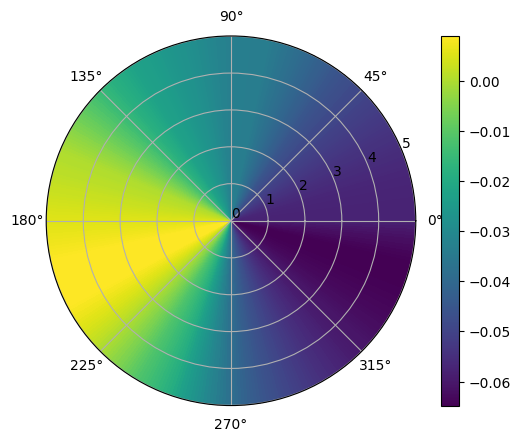

after training!


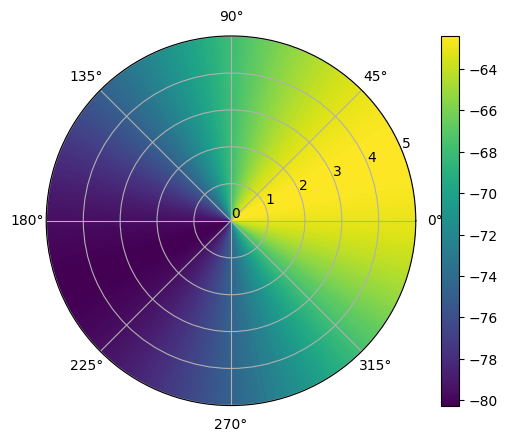

*******************************************************************************************
(action 2 = -1 , velocity 2 = -2.5 )
before training!


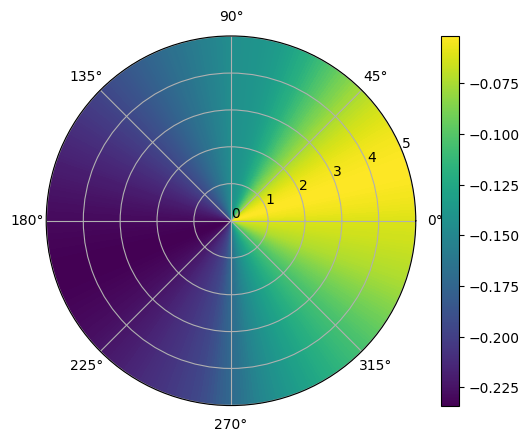

after training!


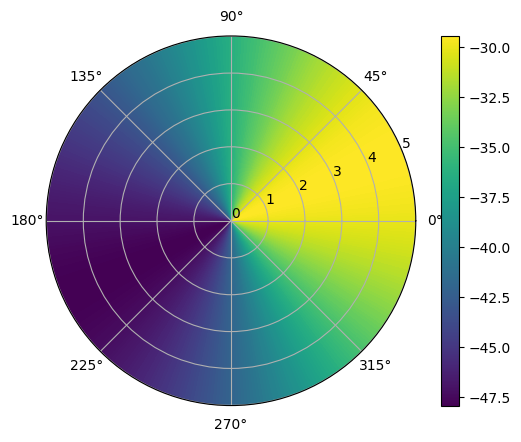

*******************************************************************************************
(action 3 = 0 , velocity 3 = 0 )
before training!


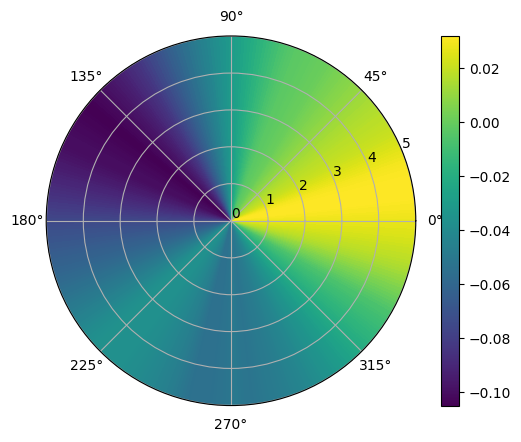

after training!


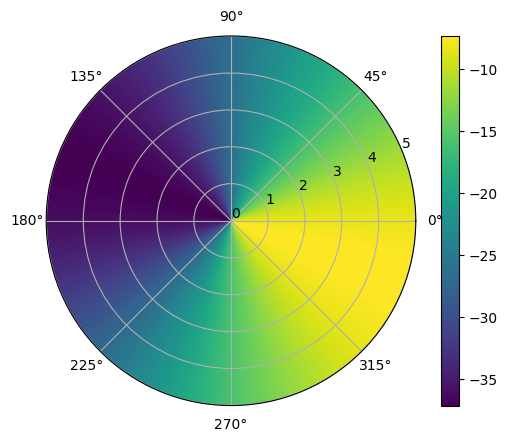

*******************************************************************************************
(action 4 = 1 , velocity 4 = 2.5 )
before training!


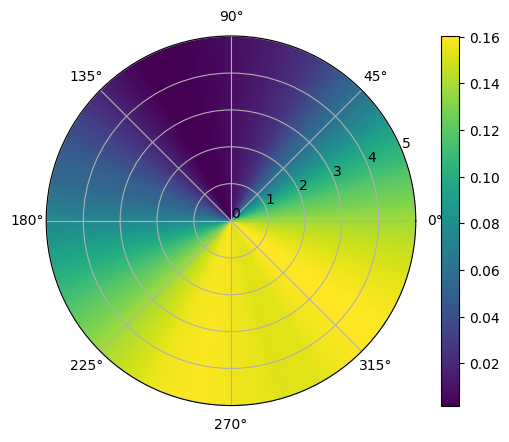

after training!


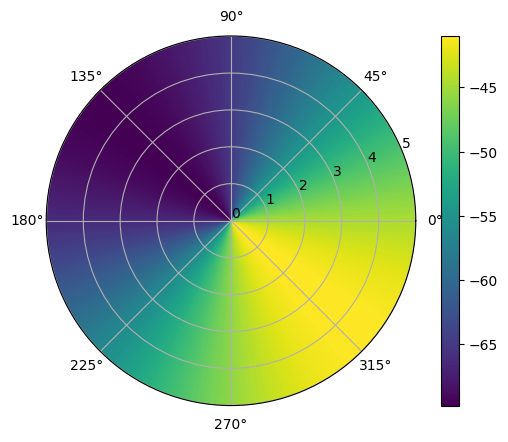

*******************************************************************************************
(action 5 = 2 , velocity 5 = 5 )
before training!


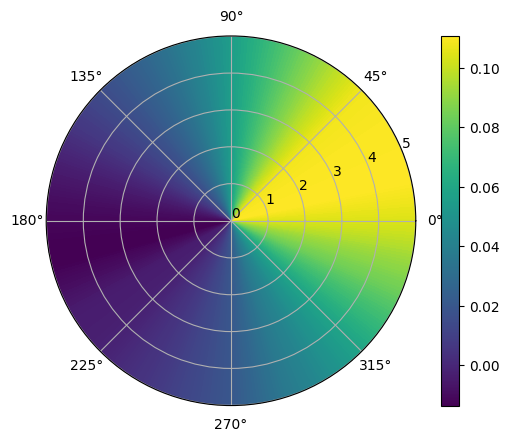

after training!


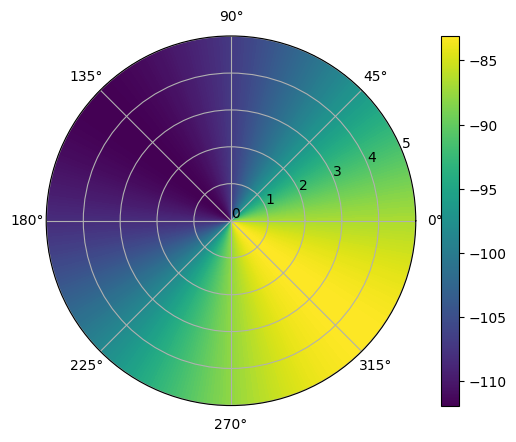

In [20]:
# plot polar heatmap 

# training the Q_Network
import copy
env = gym.make("Pendulum-v1")
print('here')
num_episode=10
batch_size=128
buffer_size=10000
gamma=0.99
learning_rate=1e-4
# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = HeuristicPendulumAgent(env)
num_step=200

normalized_env = NormalizedEnv(env)
print('Start training...')
for episode in range(num_episode):
    print('episode number:',episode,'/',num_episode,'...')
    # renew the environment for every episode
    state, info = env.reset()
    
    for step in range(num_step):
        action = agent.compute_action(state)
        normalized_action = normalized_env.action(action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=(state, normalized_action, reward, next_state, truncated)
        replay_buffer.add(transition)
        state=next_state

        if len(replay_buffer) < batch_size:
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)

        loss,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer)
        Q_target.load_state_dict(Q_network.state_dict())
print('finished training...')

#action_values= np.random.uniform(-2, 2,5)
#velocity_values= np.random.uniform(-5, 5,5)
action_values= [-2,-1,0,1,2]
velocity_values=[-5,-2.5,0,2.5,5]
angles=np.linspace(0,2*np.pi,360)
angles_cosinus=[np.cos(ang) for ang in angles]
angles_sinus=[np.sin(ang) for ang in angles]


for j in range(5):
    Q_network_before_training=QNetwork()
    states=[np.append(np.append(angles_cosinus[i],angles_sinus[i]),velocity_values[j]) for i in range(360)]
    #print('states= ', states)
    inputs=torch.tensor([np.append(states[i],action_values[j]) for i in range(360)], dtype=torch.float32)
    print ('*******************************************************************************************')
    print('(action',j+1,'=',action_values[j], ', velocity',j+1,'=',velocity_values[j], ')')
    Q_values_before_training=Q_network_before_training(inputs)
    Q_values_before_training=Q_values_before_training.detach().numpy()
    print ('before training!')
    # print('Q_values before training = ', Q_values_before_training)
    Q_Matrix_before_training=Q_values_before_training
    for i in range(359):
        Q_Matrix_before_training=np.column_stack((Q_Matrix_before_training,Q_values_before_training))
    fig_before_training = plt.figure()
    rad=np.linspace(0,5,360)
    r,th=np.meshgrid(rad,angles)
    ax_before_training = fig_before_training.add_subplot(111, polar=True)
    p_before_training = ax_before_training.pcolormesh(th, r, Q_Matrix_before_training)
    fig_before_training.colorbar(p_before_training)
    plt.show()

    Q_values_after_training = Q_network(inputs)
    Q_values_after_training = Q_values_after_training.detach().numpy()
    print ('after training!')
    # print('Q_values after training = ', Q_values_after_training)
    Q_Matrix_after_training = Q_values_after_training
    for i in range(359):
        Q_Matrix_after_training=np.column_stack((Q_Matrix_after_training,Q_values_after_training))
    fig_after_training = plt.figure()
    ax_after_training = fig_after_training.add_subplot(111, polar=True)
    p_after_training = ax_after_training.pcolormesh(th, r, Q_Matrix_after_training)
    fig_after_training.colorbar(p_after_training)
    plt.show()


## Part 5 Minimal implementation of DDPG

In [14]:
# PolicyNetwork
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, hidden_dim=32):
        super(PolicyNetwork, self).__init__()
        # input_dim: dimension of the input -> 3 elements of the state
        # hidden_dim: dimension of one hidden layer -> 32 nodes
        # output_dim: dimension of action -> a scalar (action)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        # state: state -> 3 elements of the state
        # return action 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # apply tanh to restrict the action in the range [-1, 1]
        x = F.tanh(self.fc3(x))

        return x

In [15]:
#GaussianActionNoise
class GaussianActionNoise():
    def __init__(self, sigma):
        self.sigma = sigma
        self.mu=0
    def get_noisy_action(self,action):
        noise = np.random.normal(self.mu,self.sigma)
        noisy_action = action + noise
        # clip the noisy action to be in the range [-1, 1]
        noisy_action = np.clip(noisy_action, -1, 1)
        return noisy_action

In [16]:
# DDPGAgent
class DDPGAgent():
    def __init__(self,env,sigma):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.agent_name='DDPGAgent'
        self.action_noise=GaussianActionNoise(sigma)

    def compute_action(self,policy_network,state,deterministic=True):
        # deterministic: regulates whether to add random noise to the action or not
        with torch.no_grad():
            # convert state to tensor
            state = torch.tensor(state, dtype=torch.float)
            # compute the action
            action = policy_network(state)
            if not deterministic:
                # add random noise to the action
                action = self.action_noise.get_noisy_action(action)
            # convert action to numpy array
            action = action.numpy()
        return action

In [17]:
# Train PolicyNetwork
def train_PolicyNetwork(policy_network,Q_network, batch, optimizer):
    # print("HERE TRAIN")
    # optimizer: optimizer
    
    # unpack the batch of transitions
    state_batch=torch.tensor([transition[0] for transition in batch], dtype=torch.float)

    # clear the gradients of the optimizer
    optimizer.zero_grad()

    
    # policy_network: policy use for action selection
    predicted_action = policy_network(state_batch)
    # with torch.no_grad():
    # compute the Q values of the current state + predicted action pair
    Q_values = Q_network(torch.cat((state_batch,predicted_action),1))
        
    # print("Q_values:",Q_values)
    # print(' -Q_values.mean():', -Q_values.mean())
    # compute the loss
    loss = -Q_values.mean()
    
    
    # compute the gradients of the loss
    loss.backward()
    
    # update the weights of the Q network
    optimizer.step()
    
    return loss.item(), policy_network, predicted_action

Start training...
episode number: 0 / 10 ...
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer d

c:\Users\yasmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode number: 1 / 10 ...
episode number: 2 / 10 ...
episode number: 3 / 10 ...
episode number: 4 / 10 ...
episode number: 5 / 10 ...
episode number: 6 / 10 ...
episode number: 7 / 10 ...
episode number: 8 / 10 ...
episode number: 9 / 10 ...
Finishing training!
Save the model...
Qnetwork Model save to  trained_model\5_Qnetwork_DDPG_202305081353_ep10.pth  !
Policy network Model save to  trained_model\5_Policynetwork_DDPG_202305081353_ep10.pth  !
Save the figures...


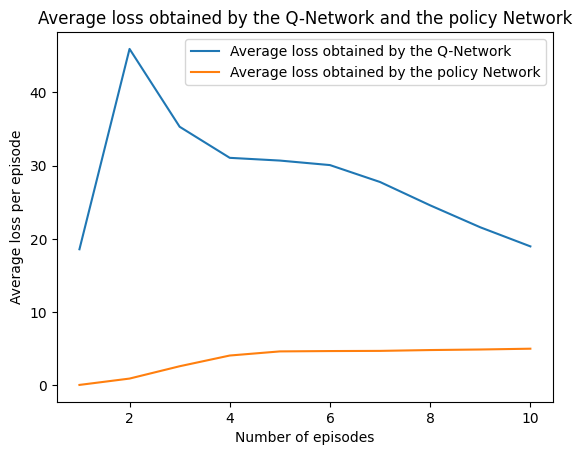

Save the figures...


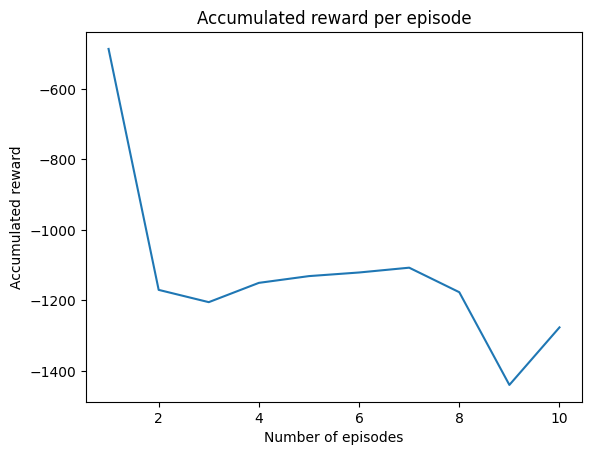

In [ ]:
env = gym.make("Pendulum-v1")
num_episode=10 #1000
num_step=200
batch_size=128
buffer_size=100000
gamma=0.99
learning_rate=1e-4
sigma=0.3
deterministic=False
list_average_loss_Q_network=[]
list_average_loss_policy_network=[]
list_reward=[]
# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
# define policy network
policy_network=PolicyNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = DDPGAgent(env,sigma)

print('Start training...')
for episode in range(num_episode):
    sum_reward=0
    print('episode number:',episode,'/',num_episode,'...')
    # initialize the sum_loss for each episode
    sum_loss_Q_network=0
    sum_loss_policy_network=0
    # renew the environment for every episode
    state, info = env.reset()
    normalized_env = NormalizedEnv(env)
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        
        # add transition to replay buffer, and kick out the old one if the buffer is full
        # add noise to action when deterministic=False
        action = agent.compute_action(policy_network,state,deterministic)
        # print('action:',action)
        normalized_action = normalized_env.action(action)
        # print('normalized_action:',normalized_action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=(state, normalized_action, reward, next_state, truncated)
        replay_buffer.add(transition)
        state=next_state

        if len(replay_buffer) < batch_size:
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)

        # train the policy_network
        loss_policy_network,policy_network,predict_actions=train_PolicyNetwork(policy_network,Q_network, batch, optimizer)
        predict_rewards=0
        for batch_idx in range(batch_size):
            normalized_predict_action = normalized_env.action(predict_actions[batch_idx].item())
            _, predict_reward, _, _, _ = env.step(normalized_predict_action)
            predict_rewards+=predict_reward
        avg_predict_reward=predict_rewards/batch_size
        sum_reward+=avg_predict_reward
        # TODO: check with TA if it is correct 
        loss_Q_network,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=None,policy_network=policy_network,deterministic=deterministic)
        if loss_Q_network is not None:
            sum_loss_Q_network+=loss_Q_network
        if loss_policy_network is not None:   
            sum_loss_policy_network+=loss_policy_network
        Q_target.load_state_dict(Q_network.state_dict())
        
    average_loss_Q_network=sum_loss_Q_network/num_step
    average_loss_policy_network=sum_loss_policy_network/num_step
    list_average_loss_Q_network.append(average_loss_Q_network)
    list_average_loss_policy_network.append(average_loss_policy_network)
    list_reward.append(sum_reward)
print('Finishing training!')
print('Save the model...')
# save the model with path name with real-time date and time
save_path_Q= os.path.join('trained_model','5_Qnetwork_DDPG_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
torch.save(Q_network.state_dict(), save_path_Q)
print('Qnetwork Model save to ',save_path_Q,' !')
save_path_Policy= os.path.join('trained_model','5_Policynetwork_DDPG_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
torch.save(policy_network.state_dict(), save_path_Policy)
print('Policy network Model save to ',save_path_Policy,' !')

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_average_loss_Q_network, label='Average loss obtained by the Q-Network')
plt.plot(list_number_episodes,list_average_loss_policy_network, label='Average loss obtained by the policy Network')
plt.xlabel('Number of episodes')
plt.ylabel('Average loss per episode')
plt.title('Average loss obtained by the Q-Network and the policy Network')
plt.legend()
print('Save the figures...')
image_path=os.path.join('figure','5_AverageLoss_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
plt.figure()
plt.plot(list_number_episodes,list_reward)
plt.xlabel('Number of episodes')
plt.ylabel('Accumulated reward')
plt.title('Accumulated reward per episode')
print('Save the figures...')
image_path=os.path.join('figure','5_AccumulatedRewardPerEpisode__'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
env.close()

Start testing...
episode number: 0 / 100 ...
episode number: 1 / 100 ...
episode number: 2 / 100 ...
episode number: 3 / 100 ...
episode number: 4 / 100 ...
episode number: 5 / 100 ...
episode number: 6 / 100 ...
episode number: 7 / 100 ...
episode number: 8 / 100 ...
episode number: 9 / 100 ...
episode number: 10 / 100 ...
episode number: 11 / 100 ...
episode number: 12 / 100 ...
episode number: 13 / 100 ...
episode number: 14 / 100 ...
episode number: 15 / 100 ...
episode number: 16 / 100 ...
episode number: 17 / 100 ...
episode number: 18 / 100 ...
episode number: 19 / 100 ...
episode number: 20 / 100 ...
episode number: 21 / 100 ...
episode number: 22 / 100 ...
episode number: 23 / 100 ...
episode number: 24 / 100 ...
episode number: 25 / 100 ...
episode number: 26 / 100 ...
episode number: 27 / 100 ...
episode number: 28 / 100 ...
episode number: 29 / 100 ...
episode number: 30 / 100 ...
episode number: 31 / 100 ...
episode number: 32 / 100 ...
episode number: 33 / 100 ...
episode

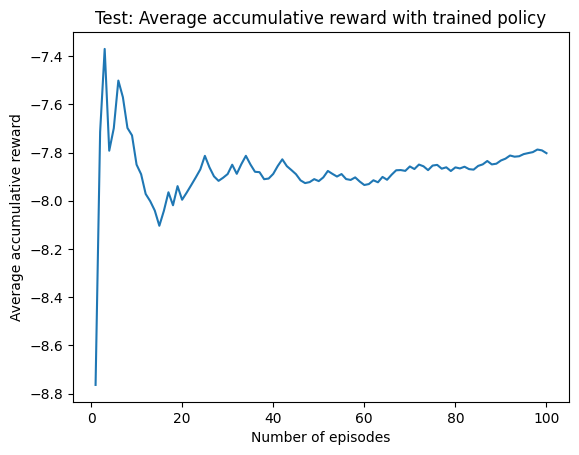

In [ ]:
# Excute Test with the trained model

env = gym.make("Pendulum-v1")
num_episode=100
num_step=200
sigma=0.3
deterministic=True
episode_accumulated_reward=0
list_avg_accumulated_reward=[]

# get the model weight
policy_model_path=os.path.join('trained_model','5_Policynetwork_DDPG_202305042005_ep10.pth')
qnetwork_model_path=os.path.join('trained_model','5_Qnetwork_DDPG_202305042005_ep10.pth')
# initialize the Q network with the stored model
Q_network=QNetwork()
Q_network.load_state_dict(torch.load(qnetwork_model_path))
# initialize the policy network with the stored model
policy_network=PolicyNetwork()
policy_network.load_state_dict(torch.load(policy_model_path))

# define agent
agent = DDPGAgent(env,sigma)

print('Start testing...')
for episode in range(num_episode):
    sum_reward=0
    print('episode number:',episode,'/',num_episode,'...')
    # initialize the sum_loss for each episode
    sum_loss_Q_network=0
    sum_loss_policy_network=0
    # renew the environment for every episode
    state, info = env.reset()
    normalized_env = NormalizedEnv(env)
    with torch.no_grad():
        for step in range(num_step):
            # print('step:',step,'/',num_step,'...')
            
            # create new transition/data
            # do not add noise to action by deterministic=True
            action = agent.compute_action(policy_network,state,deterministic)
            # print('action:',action)
            normalized_action = normalized_env.action(action)
            # print('normalized_action:',normalized_action)
            next_state, reward, terminated, truncated, info = env.step(normalized_action)
            state=next_state
        
            # unpack the batch of transitions
            # only 1 btach here since here is testing
            state_batch=torch.tensor([state], dtype=torch.float)

            # policy_network: policy use for action selection
            predicted_action = policy_network(state_batch)
            
            # print('predicted_action:',predicted_action.item())
            normalized_predict_action = normalized_env.action(predicted_action.item())
            _, predict_reward, _, _, _ = env.step(normalized_predict_action)
            
            sum_reward+=predict_reward
        episode_accumulated_reward+=sum_reward/num_step
        list_avg_accumulated_reward.append(episode_accumulated_reward/(episode+1))

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_avg_accumulated_reward)
plt.xlabel('Number of episodes')
plt.ylabel('Average accumulative reward')
plt.title('Test: Average accumulative reward with trained policy')
print('Save the figures...')
image_path=os.path.join('figure','5_TestAvgAccumulativeReward__'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
env.close()



Start training...
episode number: 0 / 10 ...
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer d

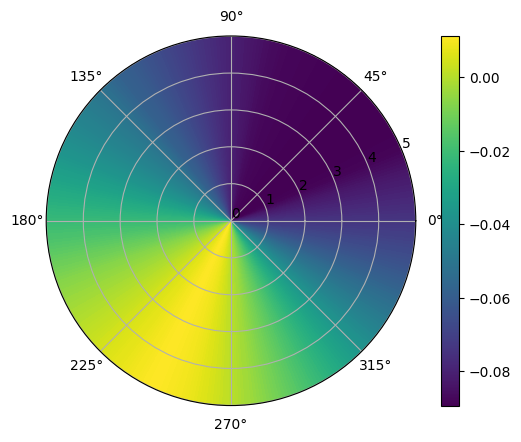

after training!


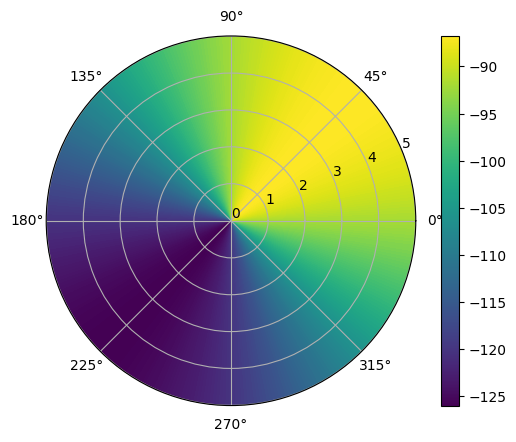

*******************************************************************************************
(action 2 = -1  , velocity 2 = -2.5 )
before training!


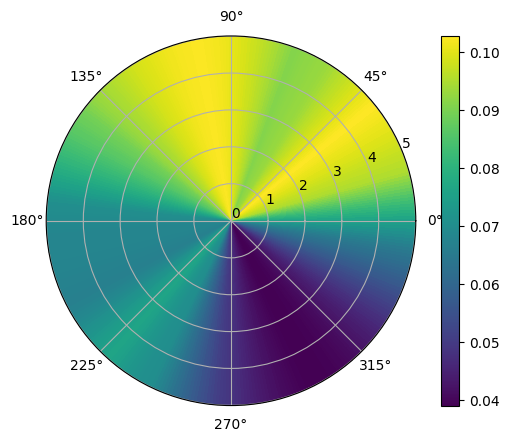

after training!


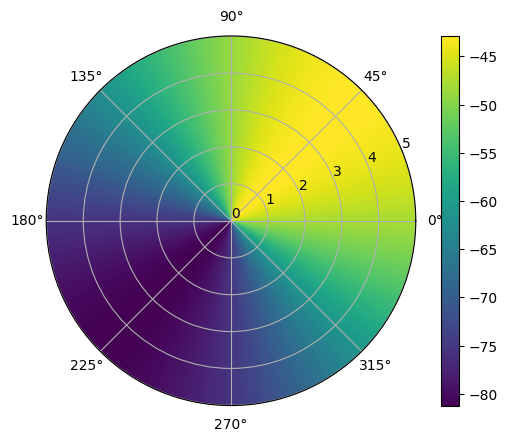

*******************************************************************************************
(action 3 = 0  , velocity 3 = 0 )
before training!


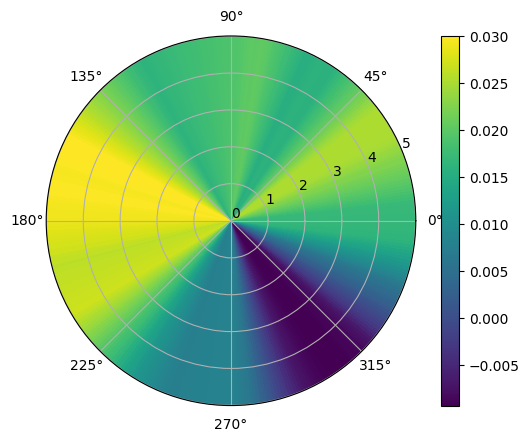

after training!


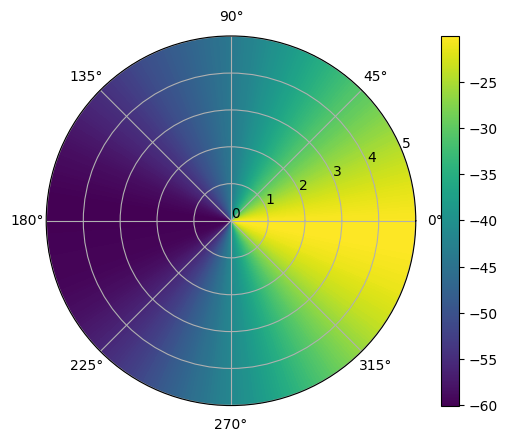

*******************************************************************************************
(action 4 = 1  , velocity 4 = 2.5 )
before training!


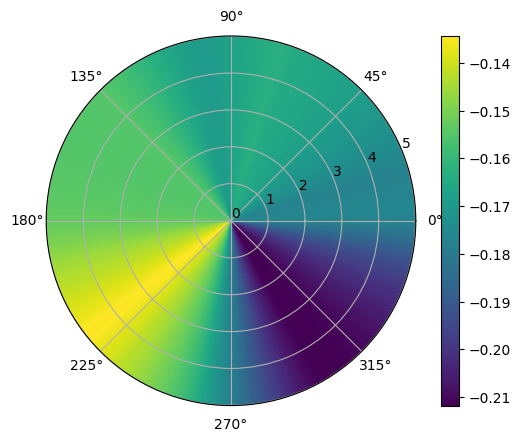

after training!


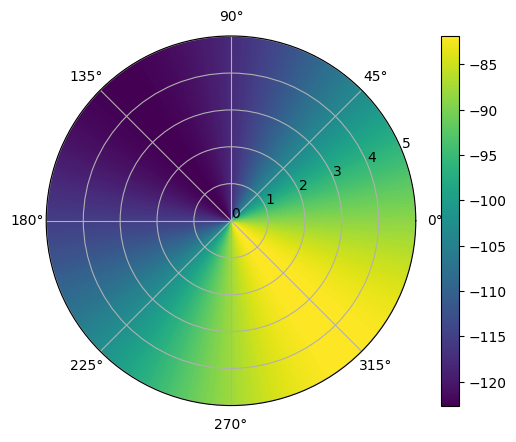

*******************************************************************************************
(action 5 = 2  , velocity 5 = 5 )
before training!


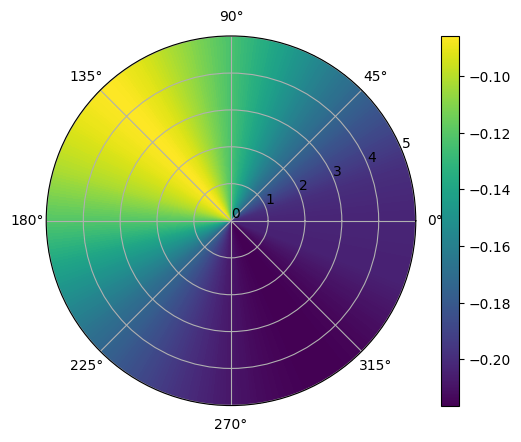

after training!


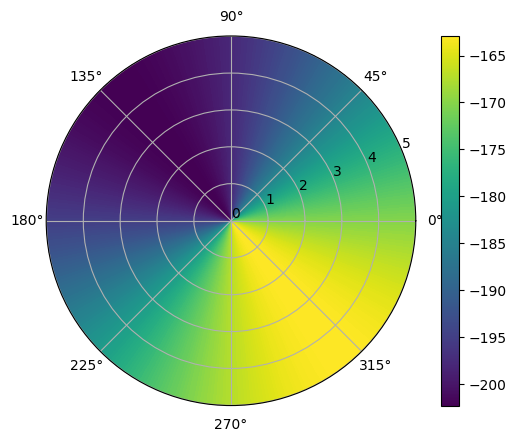

In [21]:
# polar heatmap 
env = gym.make("Pendulum-v1")
num_episode=10 #100
num_step=200
batch_size=128
buffer_size=100000
gamma=0.99
learning_rate=1e-4
sigma=0.3
deterministic=False
# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
# define policy network
policy_network=PolicyNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = DDPGAgent(env,sigma)

print('Start training...')
for episode in range(num_episode):
    print('episode number:',episode,'/',num_episode,'...')
    # renew the environment for every episode
    state, info = env.reset()
    normalized_env = NormalizedEnv(env)
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        
        # add transition to replay buffer, and kick out the old one if the buffer is full
        # add noise to action when deterministic=False
        action = agent.compute_action(policy_network,state,deterministic)
        normalized_action = normalized_env.action(action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=(state, normalized_action, reward, next_state, truncated)
        replay_buffer.add(transition)
        state=next_state

        if len(replay_buffer) < batch_size:
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)

        # train the policy_network
        loss_policy_network,policy_network,predict_actions=train_PolicyNetwork(policy_network,Q_network, batch, optimizer) 
        loss_Q_network,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=None,policy_network=policy_network,deterministic=deterministic)
        Q_target.load_state_dict(Q_network.state_dict())
        
#action_values= np.random.uniform(-2, 2,5)
#velocity_values= np.random.uniform(-5, 5,5)
action_values= [-2,-1,0,1,2]
velocity_values=[-5,-2.5,0,2.5,5]
angles=np.linspace(0,2*np.pi,360)
angles_cosinus=[np.cos(ang) for ang in angles]
angles_sinus=[np.sin(ang) for ang in angles]


for j in range(5):
    Q_network_before_training=QNetwork()
    states=[np.append(np.append(angles_cosinus[i],angles_sinus[i]),velocity_values[j]) for i in range(360)]
    #print('states= ', states)
    inputs=torch.tensor([np.append(states[i],action_values[j]) for i in range(360)], dtype=torch.float32)
    print ('*******************************************************************************************')
    print('(action',j+1,'=',action_values[j], ' , velocity',j+1,'=',velocity_values[j], ')')
    Q_values_before_training=Q_network_before_training(inputs)
    Q_values_before_training=Q_values_before_training.detach().numpy()
    print ('before training!')
    # print('Q_values before training = ', Q_values_before_training)
    Q_Matrix_before_training=Q_values_before_training
    for i in range(359):
        Q_Matrix_before_training=np.column_stack((Q_Matrix_before_training,Q_values_before_training))
    fig_before_training = plt.figure()
    rad=np.linspace(0,5,360)
    r,th=np.meshgrid(rad,angles)
    ax_before_training = fig_before_training.add_subplot(111, polar=True)
    p_before_training = ax_before_training.pcolormesh(th, r, Q_Matrix_before_training)
    fig_before_training.colorbar(p_before_training)
    plt.show()

    Q_values_after_training = Q_network(inputs)
    Q_values_after_training = Q_values_after_training.detach().numpy()
    print ('after training!')
    # print('Q_values after training = ', Q_values_after_training)
    Q_Matrix_after_training = Q_values_after_training
    for i in range(359):
        Q_Matrix_after_training=np.column_stack((Q_Matrix_after_training,Q_values_after_training))
    fig_after_training = plt.figure()
    ax_after_training = fig_after_training.add_subplot(111, polar=True)
    p_after_training = ax_after_training.pcolormesh(th, r, Q_Matrix_after_training)
    fig_after_training.colorbar(p_after_training)
    plt.show()